Effect of methane content on the thermodynamics   
All calculations are done for the production of 1 mol of Fe   
Enthalpy values have been calculated from NIST-JANAF Thermochemical Tables   

FewO+H2 = w Fe+ H2O   Eq. 6  
FewO+CO = w Fe+ CO    Eq. 6  
xCO≥(1+1/KwCO)/w*(1-beta)  Eq. 4  
jetaH2≥(1+1/KwH2)/w*beta   Eq. 5  
w/(4w-3)Fe3O4+H2=w/(4w-3)FewO+H2O  Eq. 7  
w/(4w-3)Fe3O4+CO=w/(4w-3)FewO+CO2  Eq. 7  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots as sp
import matplotlib.cm as cm
import os
import math
import ast
from scipy.optimize import fsolve
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [2]:
# Calculation of alpha according to Eq. 6
def alpha(x_ratio,T):
    value1=H2_FewO_Fe(T)*x_ratio*(1+CO_FewO_Fe(T))/((1+H2_FewO_Fe(T))*\
                                                    (1-x_ratio)*CO_FewO_Fe(T))
    value = value1/(1+value1)
    return value

In [3]:
# Calculation according to Eq. 4
def xCO(x_ratio,T,w):
    value1=(1+1/CO_FewO_Fe(T))/w*(1-alpha(x_ratio,T))
    return value1

In [4]:
# Calculation according to Eq. 5
def jietaH2(x_ratio,T,w):
    value1=(1+1/H2_FewO_Fe(T))/w*alpha(x_ratio,T)
    
    return value1

In [5]:
#Calculation according to Eq. 9 
def rCO(x_CO, alpha, w):
    value=x_CO-(1-alpha(x_ratio,T))/w
    #print('rCO:', value)
    return value
def fCO(x_CO,alpha, w,jieta_H2,T,pusai_H2):
    return rCO(x_CO, alpha, w)-\
    (1-beta(jieta_H2,x_CO, alpha, w,T,pusai_H2))\
    *(4*w-3)/(3*w)

def aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2):
    return fCO(x_CO, alpha, w,jieta_H2,T,pusai_H2)-\
    (1-gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2))/6

In [6]:
#Calculation according to Eq. 10
def tCO2( alpha, w):
    value=(1-alpha(x_ratio,T))/w
    #print('tCO2:', value)
    return value
def gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return tCO2( alpha, w)+\
    (1-beta(jieta_H2,x_CO, alpha, w,T,pusai_H2))*\
     (4*w-3)/(3*w)

def bCO2(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
    (1-gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2))/6

In [7]:
#Calculation according to Eq. 11 
def uH2(jieta_H2, alpha, w,pusai_H2):
    value = jieta_H2 + pusai_H2  - alpha(x_ratio,T) / w
    #print('uH2:', value)
    return value
def jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return uH2(jieta_H2, alpha, w,pusai_H2)-\
           beta(jieta_H2,x_CO, alpha, w,T,pusai_H2)*\
            (4*w-3)/(3*w)

def dH2(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)-\
           gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2)/6

In [8]:
#Calculation according to Eq. 12 
def vH2O(alpha, w):
    value=alpha(x_ratio,T)/w
    #print('vH2O:', value)
    return value
def mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return vH2O(alpha, w)+\
           beta(jieta_H2,x_CO, alpha, w,T,pusai_H2)*\
           (4*w-3)/(3*w)

def eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    return mH2O(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
    gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2)/6

In [9]:
#Calculation of beta according to Eq. 7
def beta(jieta_H2,x_CO, alpha, w,T,pusai_H2):
    H2solution=(uH2(jieta_H2, alpha, w,pusai_H2)*H2_Fe3O4_FewO(T)-vH2O(alpha, w))/(1+H2_Fe3O4_FewO(T))
    COsolution=(rCO(x_CO,alpha, w)*CO_Fe3O4_FewO(T)-tCO2(alpha, w))/(1+CO_Fe3O4_FewO(T))
    value=H2solution/(H2solution+COsolution)
    return value

In [10]:
#Calculation according to Eq. 8
def gamma(jieta_H2, alpha, w, x_CO,T,pusai_H2):
    return jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
           (jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+\
            fCO(x_CO,alpha, w,jieta_H2,T,pusai_H2))

In [11]:
def CO_FewO_Fe(T):
    lgK=logKf("CO2", T+273.15) - logKf("FewO", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K
def CO_Fe3O4_FewO(T):
    lgK=3/(4*0.947-3)*logKf("FewO", T+273.15)+logKf("CO2", T+273.15) - 0.947/(4*0.947-3)*logKf("Fe3O4", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K
def H2_FewO_Fe(T):
    lgK=logKf("H2O", T+273.15) - logKf("FewO", T+273.15) 
    K = 10 ** lgK
    return K
def H2_Fe3O4_FewO(T):
    lgK=3/(4*0.947-3)*logKf("FewO", T+273.15)+logKf("H2O", T+273.15) - 0.947/(4*0.947-3)*logKf("Fe3O4", T+273.15) 
    K = 10 ** lgK
    return K


In [12]:
#CO+H2O=CO2+H2
def K_WGSR(T):
    lgK=logKf("CO2", T+273.15) -logKf("H2O", T+273.15) - logKf("CO", T+273.15)
    K = 10 ** lgK
    return K
#CH4+CO2+2CO+2H2
def K_DIR(T):
    lgK=2*logKf("CO", T+273.15)-logKf("CH4", T+273.15)- logKf("CO2", T+273.15)  
    K = 10 ** lgK
    return K

In [13]:
#Calculation according to Eq. 20
def heatgasin(T, Tout,jieta_H2,alpha, w, x_CO):
    deltaHinH2=H2_enthalpy(T+273) - H2_enthalpy(273+25)
    deltaHinCO=CO_enthalpy(T+273)- CO_enthalpy(273+25)
    deltaHinCH4= CH4_enthalpy(T+273)- CH4_enthalpy(273+25)
    Qin=deltaHinH2*jieta_H2+deltaHinCO*x_CO+\
         ((jieta_H2+x_CO)*omegaCH4/(1-omegaCH4))*deltaHinCH4#降温到25℃时放出的热量
    return Qin
def heatgasout(T, Tout,jieta_H2,alpha, w, x_CO):
    a=aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)
    b=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
    d=dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)
    e=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)
    deltaHoutH2=H2_enthalpy(Tout+273) - H2_enthalpy(273+25)
    deltaHoutCO=CO_enthalpy(Tout+273)- CO_enthalpy(273+25)
    deltaHoutCH4= CH4_enthalpy(Tout+273)- CH4_enthalpy(273+25)
    deltaHoutH2O= H2O_enthalpy(Tout+273)- H2O_enthalpy(273+25)
    deltaHoutCO2= CO2_enthalpy(Tout+273)- CO2_enthalpy(273+25)
    Qout=deltaHoutH2*d+deltaHoutCO*a+deltaHoutH2O*e+\
         deltaHoutCO2*b+cCH4(carbon_ratio, omegaCH4,jieta_H2)*deltaHoutCH4#升温到排出时吸收的热量
    return Qout
def heatgas(T, Tout,jieta_H2,alpha, w, x_CO,omegaCH4,carbon_ratio,cCH4):
    value=heatgasout(T, Tout,jieta_H2,alpha, w, x_CO)-heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)
    return value


In [14]:
##Calculation according to Eq. 15-18
def carbon_ratio_equation(y, T, n_CH4, n_total, p, jieta_H2):
    if T<842:
        delta_G = 26668 - 23.49 * (T + 273)
        lnaFe1 = (delta_G - 8.314 * (T+273) * np.log((n_CH4-y) * (n_total + y) * p/((jieta_H2 + 2*y) * p)** 2)+\
                 91044 - 110.67 * (T+273))/(3*8.314*(T+273))
        return 3.3 * (y ** 2) + y + lnaFe1
    else:
        delta_G=10346-10.16*(T+273)
        lnaFe1 = (delta_G - 8.314 * (T+273) * np.log((n_CH4-y) * (n_total + y) * p /((jieta_H2 + 2*y) * p)** 2)+\
                 91044 - 110.67 * (T+273))/(3*8.314*(T+273))
        return 3.3 * (y ** 2) + y + lnaFe1
def carbon_ratio(T, xratio, omegaCH4, p, jieta_H2):
    
        
        n_CH4 = jieta_H2 * omegaCH4 / ((1 - omegaCH4) * xratio)  # 入口处甲烷的物质的量
        n_total = jieta_H2 / ((1 - omegaCH4) * xratio)  # 入口处总的物质的量

        # 初始猜测值
        if omegaCH4<0.039:
            initial_guess = 0.05
            
        elif omegaCH4<0.1:
            if jieta_H2<=1.4:
                initial_guess = 0.12
            elif jieta_H2<=1.406:
                initial_guess = 0.13
            else:
                initial_guess = 0.11
        elif omegaCH4<0.35:
            initial_guess = 0.135

        # 使用 fsolve 求解方程
        result = fsolve(carbon_ratio_equation, initial_guess, args=(T, n_CH4, n_total, p, jieta_H2))

        if result:
            # 如果有解，返回解的值
            return result[0]
        else:
            # 如果无解，返回0或其他值
            return 0
   

In [15]:
#outlet of methane
def cCH4(carbon_ratio, omegaCH4,jieta_H2):
    n_CH4 = jieta_H2 * omegaCH4 / ((1 - omegaCH4) * xratio)
    value=n_CH4-carbon_ratio(T, x_ratio, omegaCH4, p, jieta_H2)
    return value

In [16]:
def energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    H298K=0+1.5*(-393.522)+0.5*825.5+1.5*110.53
    value=bCO2(jieta_H2,alpha, w, x_CO,T,pusai_H2)/1.5*H298K
    return value
def energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2):
    H298K=0+1.5*(-241.826)+0.5*825.5
    value=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/1.5*H298K    
    return value
def energy_carburization(carbon_ratio):
    H298K=0+25.104+74.873
    value=carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)*H298K    
    return value

In [17]:

def fe_enthalpy(T):
    t=T/1000
    A=23.97449
    B=8.367750
    C=0.000277
    D=-0.000088
    E=-0.000005
    F=0.268027
    G=62.06336
    H=7.788015    
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def Al2O3_enthalpy(T):
    t=T/1000
    A=106.0880
    B=36.33740
    C=-13.86730
    D=2.141221
    E=-3.133231
    F=-1705.970
    G=153.9350
    H=-1662.300  
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def sio2_enthalpy(T):
    t=T/1000
    A=58.75
    B=10.279
    C=-0.131384
    D=0.025210
    E=0.025601
    F=-929.3292
    G=105.8092
    H=-910.8568   
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def H2_enthalpy(T):
    t=T/1000
    A=18.563083
    B=12.257357
    C=-2.859786
    D=0.268239
    E=1.97799
    F=-1.147438
    G=156.288133
    H=0 
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def H2O_enthalpy(T):
    t=T/1000
    A=30.092
    B=6.832514
    C=6.793435	
    D=-2.534480
    E=0.082139
    F=-250.881
    G=223.3967
    H=-241.8264
    H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CO_enthalpy(T):
    if T<1300:
        t=T/1000
        A=25.56759
        B=6.09613
        C=4.054656
        D=-2.671301
        E=0.131021
        F=-118.0089
        G=227.3665
        H=-110.5271
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=35.1507
        B=1.300095
        C=-0.205921
        D=0.01355
        E=-3.28278
        F=-127.8375
        G=231.7120
        H=-110.5271
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CO2_enthalpy(T):
    if T<1200:
        t=T/1000
        A=24.99735
        B=55.18696
        C=-33.69137	
        D=7.94838
        E=-0.136638
        F=-403.6075
        G=228.2431
        H=-393.5224
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=58.16639
        B=2.720074
        C=-0.492289
        D=0.038844
        E=-6.447293
        F=-425.9186
        G=263.6125
        H=-393.5224
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t
def CH4_enthalpy(T):
    if T<1300:
        t=T/1000
        A=-0.703029
        B=108.4773
        C=-42.52157
        D=5.862788
        E=0.678565
        F=-76.84376
        G=158.7163
        H=-74.8731
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    else:
        t=T/1000
        A=85.81217
        B=11.26467
        C=-2.114146
        D=0.138190
        E=-26.42221
        F=-153.5327
        G=224.4143
        H=-74.87310
        H_t=A*t +(B*t*t)/2 +(C*t*t*t)/3 + (D*t*t*t*t)/4-(E/t)+F-H
    return H_t

In [18]:
def logKf(name,T):
    def lgKf(da, db, T0):
        value = da + (db-da)/100*(T-T0)
        return value
    if name == "FewO":
        if T < 1000:
            T0=900
            da = 11.941 
            db = 10.415
        elif T < 1100:
            T0=1000
            da = 10.415 
            db = 9.161   
        elif T < 1200:
            T0=1100
            da = 9.161 
            db = 8.113
        elif T < 1300:
            T0=1200
            da = 8.113
            db = 7.226
        elif T < 1400:
            T0=1300
            da = 7.226
            db = 6.468
        elif T < 1500:
            T0=1400
            da = 6.468
            db = 5.813
        elif T < 1600:
            T0=1500
            da = 5.813
            db = 5.242  
        elif T < 1700:
            T0=1600
            da = 5.242  
            db = 4.739
        elif T < 1800:
            T0=1700
            da = 4.739
            db = 4.292
        elif T < 1900:
            T0=1800
            da = 4.292
            db = 3.874
    elif name == "Fe3O4":
        if T < 1000:
            T0=900
            da = 47.732
            db = 41.401
        elif T < 1100:
            T0=1000
            da = 41.401
            db = 36.206 
        elif T < 1200:
            T0=1100
            da = 36.206 
            db = 31.869
        elif T < 1300:
            T0=1200
            da = 31.869
            db = 28.197
        elif T < 1400:
            T0=1300
            da = 28.197
            db = 25.057
        elif T < 1500:
            T0=1400
            da = 25.057
            db = 22.341
        elif T < 1600:
            T0=1500
            da = 22.341
            db = 19.968
        elif T < 1700:
            T0=1600
            da = 19.968
            db = 17.876
        elif T < 1800:
            T0=1700
            da = 17.876
            db = 16.014
        elif T < 1900:
            T0=1800
            da = 16.014
            db = 14.29
    elif name == "H2O":
        if T < 700:
            T0=600
            da = 18.631
            db = 15.582
        elif T < 1000:
            T0=900
            da = 11.496
            db = 10.06
        elif T < 1100:
            T0=1000
            da = 10.06
            db = 8.881
        elif T < 1200:
            T0=1100
            da = 8.881
            db = 7.897
        elif T < 1300:
            T0=1200
            da = 7.897
            db = 7.063
        elif T < 1400:
            T0=1300
            da = 7.063
            db = 6.346
        elif T < 1500:
            T0=1400
            da = 6.346
            db = 5.724
        elif T < 1600:
            T0=1500
            da = 5.724
            db = 5.179
        elif T < 1700:
            T0=1600
            da = 5.179
            db = 4.698
        elif T < 1800:
            T0=1700
            da = 4.698
            db = 4.269
        elif T < 1900:
            T0=1800
            da = 4.269
            db = 3.885
    elif name == "CO":
        if T < 700:
            T0=600
            da = 14.32
            db = 12.948
        elif T < 1000:
            T0=900
            da = 11.109
            db = 10.461
        elif T < 1100:
            T0=1000
            da = 10.461
            db = 9.928
        elif T < 1200:
            T0=1100
            da = 9.928
            db = 9.481
        elif T < 1300:
            T0=1200
            da = 9.481
            db = 9.101
        elif T < 1400:
            T0=1300
            da = 9.101
            db = 8.774
        elif T < 1500:
            T0=1400
            da = 8.774
            db = 8.488
        elif T < 1600:
            T0=1500
            da = 8.488
            db = 8.236
        elif T < 1700:
            T0=1600
            da = 8.236
            db = 8.013
        elif T < 1800:
            T0=1700
            da = 8.013
            db = 7.813
        elif T < 1900:
            T0=1800
            da = 7.813
            db = 7.633
    elif name == "CO2":
        if T < 700:
            T0=600
            da = 34.404
            db = 29.505
        elif T < 1000:
            T0=900
            da = 22.969
            db = 20.679
        elif T < 1100:
            T0=1000
            da = 20.679
            db = 18.805
        elif T < 1200:
            T0=1100
            da = 18.805
            db = 17.242
        elif T < 1300:
            T0=1200
            da =17.242
            db = 15.919
        elif T < 1400:
            T0=1300
            da = 15.919
            db = 14.784
        elif T < 1500:
            T0=1400
            da = 14.784
            db = 13.8
        elif T < 1600:
            T0=1500
            da = 13.8
            db = 12.939
        elif T < 1700:
            T0=1600
            da = 12.939 
            db = 12.178
        elif T < 1800:
            T0=1700
            da = 12.178
            db = 11.502
        elif T < 1900:
            T0=1800
            da = 11.502
            db = 10.896
    elif name == "CH4":
        if T <700 :
            T0=600
            da = 1.993
            db = 0.943 
        elif T < 1000:
            T0=900
            da = -0.5
            db = -1.018
        elif T < 1100:
            T0=1000
            da = -1.018
            db = -1.447
    lgKf = lgKf(da, db, T0)
    return lgKf

In [19]:
#SiO2_mass_ratio=3
#Al2O3_mass_ratio=2
def heatsolid(Tsolid,carbon_ratio):
    if carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)<(1/3):
        
        value1=(sio2_enthalpy(Tsolid+273)-sio2_enthalpy(298))*160*0.5/0.95*0.03/60+\
               (Al2O3_enthalpy(Tsolid+273)-Al2O3_enthalpy(298))*160*0.5/0.95*0.02/102+\
               (fe_enthalpy(Tsolid+273)-fe_enthalpy(298))*(1-carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)*3)
        value2=carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)*(82.17*(Tsolid-25)+83.68/1000/2*((273.15+Tsolid)**2-(273.15+25)**2))/1000
        value=value1+value2                                     
    if carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)>(1/3):
       
        value1=(sio2_enthalpy(Tsolid+273)-sio2_enthalpy(298))*160*0.5/0.95*0.03/60+\
               (Al2O3_enthalpy(Tsolid+273)-Al2O3_enthalpy(298))*160*0.5/0.95*0.02/102
        value2=((1/3)*(82.17*(Tsolid-25)+83.68/1000/2*((273.15+Tsolid)**2-(273.15+25)**2))+(carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)-(1/3))*\
               (17.15*(Tsolid-25)+4.27/1000/2*((273.15+Tsolid)**2-(273.15+25)**2)+8.79*10000*(1/(273.15+Tsolid)-1/(273.15+25))))/1000
        value=value1+value2 
    return value

In [20]:
#Calculation according to Eq. 21
def heatcmb(carbon_ratio,bCO2):
    value=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)*283.3+285.8*(1.5-bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))+74.873*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)
    return value

In [21]:
w=0.947
T=1000#℃浮式体还原温度/气体进入温度
Tout=350#气体出去的温度
Tsolid=600#固体出去温度
omegaCH4=0.08#体积分数
p=2#atm

In [23]:
omegaCH4_values=np.arange(0.05,0.31,0.01)
T=1000
Cost_all=[]
omegaCH4_all=[]
result_data_CO = []
result_data_H2 = []
result_data_Comprehensive = []
result_data_carbon_ratio = []
result_data_gasmole = []
result_data_reductiongasmole = []
result_data_H= []
result_data_Hdeficit= []
hydrogen_carbon_ratio_range = np.arange(1,11,1)
result_data_energy=[]
for omegaCH4 in omegaCH4_values:
    H2_uti_ratio_all=[]
    CO_uti_ratio_all=[]
    Comprehensive_uti_ratio_all=[]
    gasmole_all=[]
    reductiongasmole_all=[]
    H_all=[]
    Hdeficit_all=[]
    carbon_ratio_all=[]
    energy_all=[]
    for hydrogen_carbon_ratio in hydrogen_carbon_ratio_range:
        xratio=hydrogen_carbon_ratio/(hydrogen_carbon_ratio+1)
        Kx_CO=CO_Fe3O4_FewO(T)
        Kx_H2=H2_Fe3O4_FewO(T)
        x_CO=1.5*(1-xratio)
        jieta_H2=1.5*xratio
        x_ratio=(jieta_H2+2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2))/\
               (x_CO+jieta_H2+2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2))
        pusai_H2=2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)
        while x_CO<xCO(x_ratio,T,w) or (jieta_H2+pusai_H2)<jietaH2(x_ratio,T,w):
            x_CO += 0.001
            jieta_H2=xratio*x_CO/(1-xratio)
            pusai_H2=2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)
            x_ratio=(jieta_H2+pusai_H2)/(x_CO+jieta_H2+pusai_H2)       
        Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
        Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
        while Q_CO>Kx_CO or Q_H2>Kx_H2:
            x_CO=x_CO+0.005
            jieta_H2=x_ratio*x_CO/(1-x_ratio)
            pusai_H2=2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)
            Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
            Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)

        heat_gas=heatgas(T, Tout,jieta_H2,alpha, w, x_CO,omegaCH4,carbon_ratio, cCH4)
        heat_solid=heatsolid(Tsolid,carbon_ratio)
        delta_H = energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)+energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)\
                      +energy_carburization(carbon_ratio)+heat_solid+heat_gas
        if delta_H > 0:
            Hdeficit_all.append(delta_H)  
        if delta_H < 0:
            carbonratio=carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)          
            CO_uti=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
              (aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))
            H2_uti=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/\
              (eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2))
            Comprehensive_uti=(eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))/\
                ((aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+\
                   dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)))
            gasmole=(x_CO+jieta_H2)/(1-omegaCH4)
            reductiongasmole=x_CO+jieta_H2+pusai_H2

            energy=heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)+heatcmb(carbon_ratio,bCO2)
            #print("xratio,omegaCH4 , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy :", xratio, omegaCH4 , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy)
            gasmole_all.append(gasmole)
            reductiongasmole_all.append(reductiongasmole)
            energy_all.append(energy)
            H_all.append(delta_H)              
            Hdeficit_all.append(0) 
            CO_uti_ratio_all.append(CO_uti)
            H2_uti_ratio_all.append(H2_uti)
            Comprehensive_uti_ratio_all.append(Comprehensive_uti)    
            carbon_ratio_all.append(carbonratio)
            continue

        while delta_H > 0 :
            x_CO=x_CO+0.0005
            jieta_H2=xratio*x_CO/(1-xratio)
            pusai_H2=2*carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)                
            Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
            Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)
            while Q_CO>Kx_CO or Q_H2>Kx_H2:
                    x_CO=x_CO+0.002
                    jieta_H2=x_ratio*x_CO/(1-x_ratio)
                    Q_CO=gCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/fCO(x_CO,  alpha, w,jieta_H2,T,pusai_H2)
                    Q_H2=mH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/jH2(jieta_H2, alpha, w, x_CO,T,pusai_H2)

            heat_gas=heatgas(T, Tout,jieta_H2,alpha, w, x_CO,omegaCH4,carbon_ratio, cCH4)
            heat_solid=heatsolid(Tsolid,carbon_ratio)
            delta_H = energy_COreduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)+energy_H2reduction(jieta_H2,alpha, w, x_CO,T,pusai_H2)\
                       +energy_carburization(carbon_ratio)+heat_solid+heat_gas
                #print('deltaH',delta_H)
            if delta_H <= 0:
                carbonratio=carbon_ratio(T, xratio, omegaCH4, p, jieta_H2)
                
                CO_uti=bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)/\
                          (aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))
                H2_uti=eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)/\
                        (eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2))
                Comprehensive_uti=(eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2))/\
                        ((aCO(x_CO, alpha, w, jieta_H2,T,pusai_H2)+bCO2(jieta_H2, alpha, w, x_CO,T,pusai_H2)+eH2O(jieta_H2,alpha, w, x_CO,T,pusai_H2)+\
                                                     dH2(jieta_H2,alpha, w, x_CO,T,pusai_H2)))
                gasmole=(x_CO+jieta_H2)/(1-omegaCH4)
                reductiongasmole=x_CO+jieta_H2+pusai_H2
                energy=heatgasin(T, Tout,jieta_H2,alpha, w, x_CO)+heatcmb(carbon_ratio,bCO2)

                gasmole_all.append(gasmole)
                reductiongasmole_all.append(reductiongasmole)
                energy_all.append(energy)
                H_all.append(delta_H)          
                CO_uti_ratio_all.append(CO_uti)
                H2_uti_ratio_all.append(H2_uti)
                Comprehensive_uti_ratio_all.append(Comprehensive_uti)
                carbon_ratio_all.append(carbonratio)
                #print("xratio,omegaCH4 , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy :", xratio, omegaCH4 , CO_uti,H2_uti,Comprehensive_uti,gasmole,energy)
                continue
    result_data_CO.append((omegaCH4, CO_uti_ratio_all))
    result_data_H2.append((omegaCH4, H2_uti_ratio_all))
    result_data_Comprehensive.append((omegaCH4, Comprehensive_uti_ratio_all))
    result_data_carbon_ratio.append((omegaCH4, carbon_ratio_all))
    result_data_reductiongasmole.append((omegaCH4, reductiongasmole_all))
    result_data_gasmole.append((omegaCH4, gasmole_all))
    result_data_Hdeficit.append((omegaCH4, Hdeficit_all))
    result_data_energy.append((omegaCH4, energy_all))


C:\Users\40583\AppData\Local\Temp\ipykernel_22316\2334537822.py:10: RuntimeWarning: invalid value encountered in log
  lnaFe1 = (delta_G - 8.314 * (T+273) * np.log((n_CH4-y) * (n_total + y) * p /((jieta_H2 + 2*y) * p)** 2)+\


C:\Users\40583\AppData\Local\Temp\ipykernel_22316\4117424079.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(hydrogen_carbon_ratio_range))


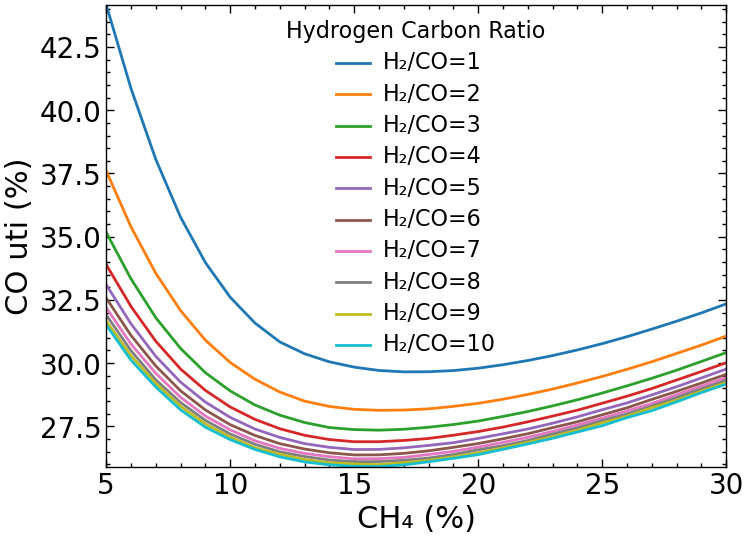

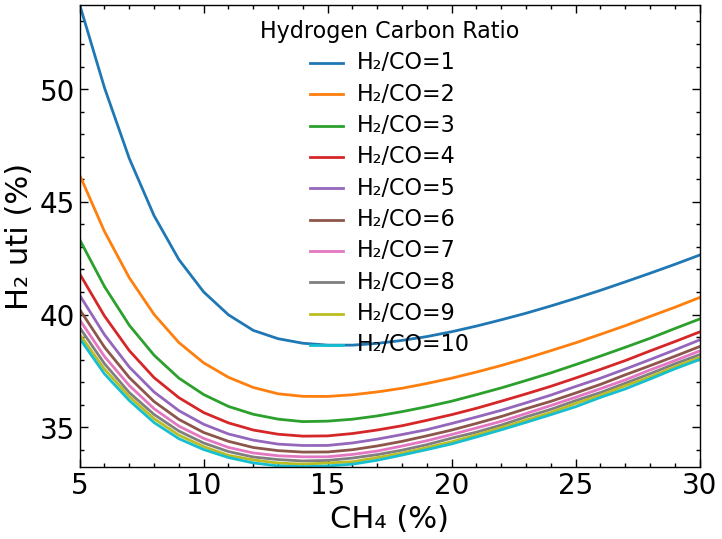

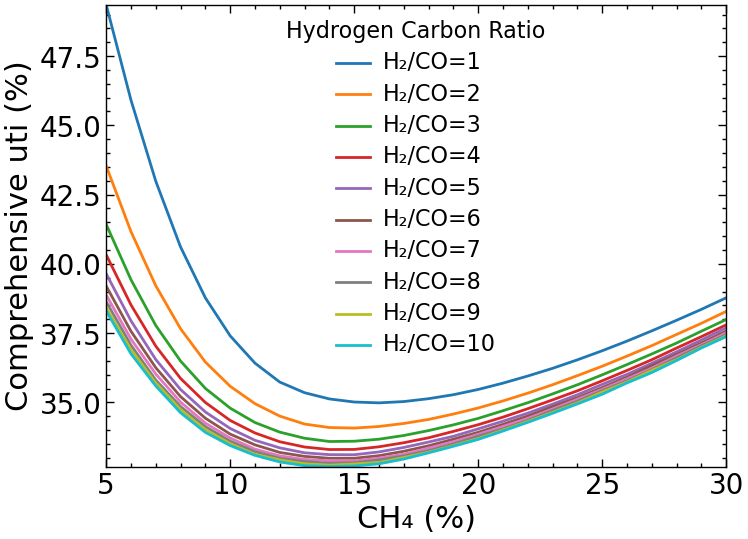

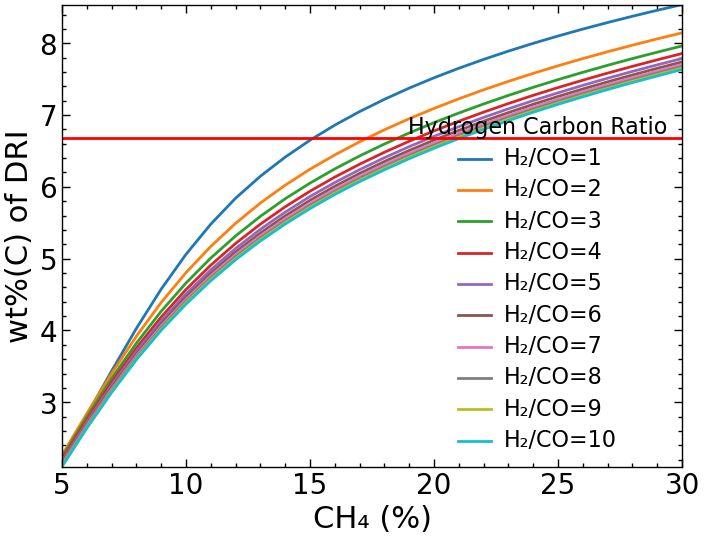

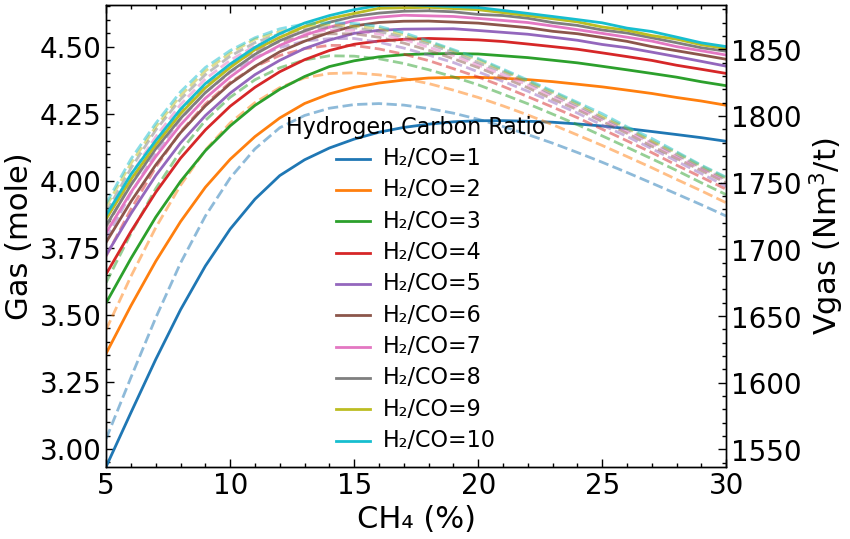

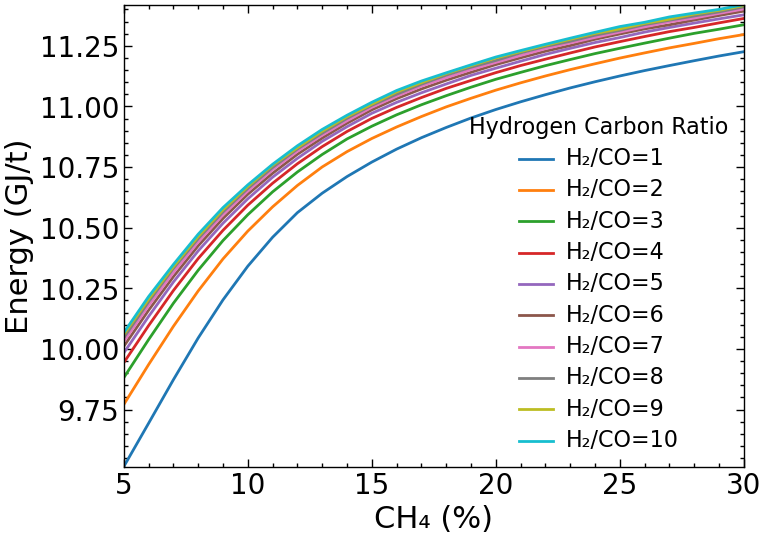

In [24]:
ratio=np.arange(0.05,0.31,0.01)
hydrogen_carbon_ratio_range = np.arange(1,11,1)
with plt.style.context(['science', 'notebook']):
    # Get built-in color cycle
    colors = cm.get_cmap('tab10', len(hydrogen_carbon_ratio_range))
    
    # Create the first plot (CO_uti vs hydrogen_carbon_ratio for Different T)
    fig1, ax1 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        CO_uti_values = [result_data_CO[j][1][i] for j in range(len(ratio))]
        color = colors(i)  # Get color from built-in color cycle
        ax1.plot(ratio*100, np.array(CO_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    legend = ax1.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax1.autoscale(tight=True)
    ax1.set_xlabel('CH₄ (%)', fontsize=22)
    ax1.set_ylabel('CO uti (%)', fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    fig1.savefig('figures3/fig_CO_Hydrogen_Carbon_Ratio.pdf')
    fig1.savefig('figures3/fig_CO_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    fig2, ax2 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        H2_uti_values = [result_data_H2[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax2.plot(ratio*100, np.array(H2_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    legend = ax2.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax2.autoscale(tight=True)
    ax2.set_xlabel('CH₄ (%)', fontsize=22)
    ax2.set_ylabel('H₂ uti (%)', fontsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    fig2.savefig('figures3/fig_H2_Hydrogen_Carbon_Ratio.pdf')
    fig2.savefig('figures3/fig_H2_Hydrogen_Carbon_Ratio.jpg', dpi=1200) 
    
    fig3, ax3 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        Comprehensive_uti_values = [result_data_Comprehensive[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax3.plot(ratio*100, np.array(Comprehensive_uti_values) * 100, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    legend = ax3.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax3.autoscale(tight=True)
    ax3.set_xlabel('CH₄ (%)', fontsize=22)
    ax3.set_ylabel('Comprehensive uti (%)', fontsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=20)
    fig3.savefig('figures3/fig_Comprehensive_Hydrogen_Carbon_Ratio.pdf')
    fig3.savefig('figures3/fig_Comprehensive_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
 
    fig4, ax4 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        carbon_ratio_values = [result_data_carbon_ratio[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax4.plot(ratio*100, np.array(carbon_ratio_values)*1200/(12+55.845), label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    legend = ax4.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax4.autoscale(tight=True)
    ax4.axhline(y=6.684, color='red', linestyle='-', label='y=0.06684')
    ax4.set_xlabel('CH₄ (%)', fontsize=22)
    ax4.set_ylabel('wt%(C) of DRI', fontsize=22)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    fig4.savefig('figures3/fig_carbon_ratio_Hydrogen_Carbon_Ratio.pdf')
    fig4.savefig('figures3/fig_carbon_ratio_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    
    fig5, ax5 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        gasmole_values = [result_data_gasmole[j][1][i] for j in range(len(ratio))]
        reductiongasmole_values = [result_data_reductiongasmole[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax5.plot(ratio*100, np.array(gasmole_values), label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
        ax5.plot(ratio*100, np.array(reductiongasmole_values), color=color, linestyle='--', alpha=0.5)
    legend = ax5.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax5.autoscale(tight=True)
    ax5_right = ax5.twinx()
    ax5_right.set_ylabel('Vgas ($\mathrm{Nm}^3/\mathrm{t}$)', fontsize=22)
    ax5_right.plot(ratio*100, np.array(gasmole_values) * 22.4 / (55.845 * 0.001), color='blue', linestyle='--', alpha=0)
    ax5.set_xlabel('CH₄ (%)', fontsize=22)
    ax5.set_ylabel('Gas (mole)', fontsize=22)
    ax5.tick_params(axis='both', which='major', labelsize=20)
    ax5_right.tick_params(axis='y', which='major', labelsize=20)
    fig5.savefig('figures3/fig_gasmole_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    
    fig6, ax6 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        energy_values = [result_data_energy[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax6.plot(ratio*100, np.array(energy_values)/55.84, label=f'H₂/CO={hydrogen_carbon_ratio}', color=color)
    legend = ax6.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax6.autoscale(tight=True)
    ax6.set_xlabel('CH₄ (%)', fontsize=22)
    ax6.set_ylabel('Energy (GJ/t)', fontsize=22)
    ax6.tick_params(axis='both', which='major', labelsize=20)
    fig6.savefig('figures3/fig_energy_Hydrogen_Carbon_Ratio.pdf')
    fig6.savefig('figures3/fig_energy_Hydrogen_Carbon_Ratio.jpg', dpi=1200)
    
    fig7, ax7 = plt.subplots()
    for i in range(len(hydrogen_carbon_ratio_range)):
        hydrogen_carbon_ratio = hydrogen_carbon_ratio_range[i]
        H_deficit_values = [result_data_Hdeficit[j][1][i] for j in range(len(ratio))]
        color = colors(i)
        ax7.plot(ratio*100, np.array(H_deficit_values),label=f'H₂/CO={hydrogen_carbon_ratio}', color=color, linestyle='--')
    legend = ax7.legend(title='Hydrogen Carbon Ratio', fontsize='large')
    legend.get_title().set_fontsize('16') 
    for label in legend.get_texts():
        label.set_fontsize('16')
    ax7.autoscale(tight=True)
    ax7.set_xlabel('CH₄ (%)', fontsize=22)
    ax7.set_ylabel('Hdeficit (kJ)', fontsize=22)
    ax7.tick_params(axis='both', which='major', labelsize=20)
    fig7.savefig('figures3/fig_H_Hydrogen_Carbon_Ratio.pdf')
    fig7.savefig('figures3/fig_H_Hydrogen_Carbon_Ratio.jpg', dpi=1200)

    plt.close()
    plt.show()